# Simulate training from notebook

In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import sys

from collections import Counter

# Setup the predictor environment

This is to simulate the loading of the modules

In [2]:
sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")

from predictor.cs_dictionary import CSDictionary
from ticks_reader import TicksReader
from cs_core import CSCore
from cs_encoder import CSEncoder
from cs_nn import CS_NN

This is to simulate the argumentes passed to the program

In [3]:
argv = ['', '-c', '../src/predictor/params.dax.yaml', '-f', '../../data/^GDAXI/dax_100.csv', '--epochs', '530', 'train']
params = CSDictionary(args=argv)

ticks_reader = TicksReader(params)
data = ticks_reader.read_ohlc()
predictor = CSCore(params)

2020-08-16 20:52:52 - INFO  - CSDictionary:__init__           - Using configuration parameters from: ../src/predictor/params.dax.yaml
2020-08-16 20:52:53 - INFO  - TicksReader:read_ohlc           - Read ticks file: ../../data/^GDAXI/dax_100.csv, output DF dim(99, 4)


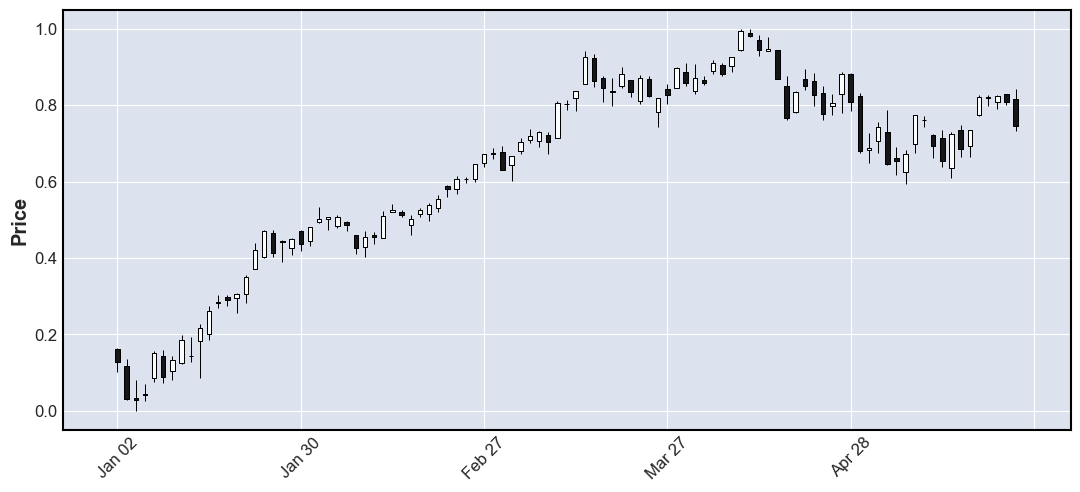

In [4]:
format = '%Y-%m-%d %H:%M:%S'
data['Datetime'] = pd.to_datetime(data['Date'] + ' 00:00:00', format=format)
data = data.set_index(pd.DatetimeIndex(data['Datetime']))
data = data.drop(['Date'], axis=1)
data.rename(columns={'Datetime':'Date'}, inplace=True)

mpf.plot(data, type='candle', columns=['o','h','l','c','v'], figsize=(14,6))

## NNs training

Encode ticks and prepare a dataset for training, with data onehot encoded.

In [5]:
params.epochs = 600
params.window_size = 4

encoder = CSEncoder(params).fit(data)
cse = encoder.transform(data)
dataset = predictor.prepare_input(encoder, cse, params.subtypes)

2020-08-16 20:52:53 - INFO  - CSEncoder:fit                   - Fitting CS encoder to ticks read.
2020-08-16 20:52:53 - INFO  - CSEncoder:_add_ohencoder        - Adding OneHot encoders for names ['body', 'move']
2020-08-16 20:52:53 - INFO  - Dataset:adjust                  - Adjusted dataset size from 99 -> 95
2020-08-16 20:52:53 - INFO  - Dataset:train_test_split        - Dataset split in train 81 and test 10
2020-08-16 20:52:53 - INFO  - Dataset:adjust                  - Adjusted dataset size from 99 -> 95
2020-08-16 20:52:53 - INFO  - Dataset:train_test_split        - Dataset split in train 81 and test 10


Create the net.

In [6]:
subtype = 'body'
body_lstm = CS_NN(params, None, subtype)

window_size = dataset[subtype].X_train.shape[1]
num_categories = dataset[subtype].X_train.shape[2]

body_lstm.build_model(window_size, num_categories)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 128)            79360     
_________________________________________________________________
dropout (Dropout)            (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 26)                3354      
Total params: 214,298
Trainable params: 214,298
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

body_lstm.train(dataset[subtype].X_train, dataset[subtype].y_train)

Epoch 1/600
Epoch 2/600
Epoch 3/600
Epoch 4/600
Epoch 5/600
Epoch 6/600
Epoch 7/600
Epoch 8/600
Epoch 9/600
Epoch 10/600
Epoch 11/600
Epoch 12/600
Epoch 13/600
Epoch 14/600
Epoch 15/600
Epoch 16/600
Epoch 17/600
Epoch 18/600
Epoch 19/600
Epoch 20/600
Epoch 21/600
Epoch 22/600
Epoch 23/600
Epoch 24/600
Epoch 25/600
Epoch 26/600
Epoch 27/600
Epoch 28/600
Epoch 29/600
Epoch 30/600
Epoch 31/600
Epoch 32/600
Epoch 33/600
Epoch 34/600
Epoch 35/600
Epoch 36/600
Epoch 37/600
Epoch 38/600
Epoch 39/600
Epoch 40/600
Epoch 41/600
Epoch 42/600
Epoch 43/600
Epoch 44/600
Epoch 45/600
Epoch 46/600
Epoch 47/600
Epoch 48/600
Epoch 49/600
Epoch 50/600
Epoch 51/600
Epoch 52/600
Epoch 53/600
Epoch 54/600
Epoch 55/600
Epoch 56/600
Epoch 57/600
Epoch 58/600
Epoch 59/600
Epoch 60/600
Epoch 61/600
Epoch 62/600
Epoch 63/600
Epoch 64/600
Epoch 65/600
Epoch 66/600
Epoch 67/600
Epoch 68/600
Epoch 69/600
Epoch 70/600
Epoch 71/600
Epoch 72/600
Epoch 73/600
Epoch 74/600
Epoch 75/600
Epoch 76/600
Epoch 77/600
Epoch 78

In [8]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 22097), started 0:32:55 ago. (Use '!kill 22097' to kill it.)